In [ ]:
'''
File 6 of 8 of kdd pipeline

Key features: investigating features and building a model for: density
'''

In [1]:
import pandas as pd

numerical_df = pd.read_csv("../dataset/cleaned_numerical_data.csv")
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [2]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [3]:
real_df['density'].describe()

count    49772.000000
mean         5.555108
std          2.972295
min          0.036012
25%          3.262820
50%          4.971475
75%          7.366337
max         26.581336
Name: density, dtype: float64

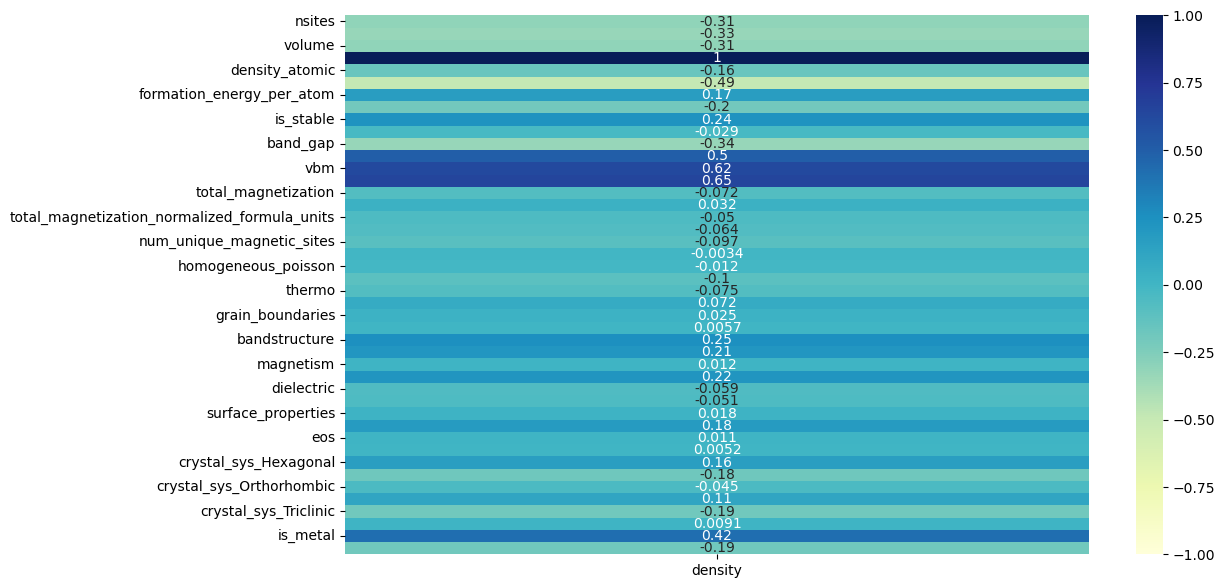

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['density']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Create the list of features to train with below
feature_names = ['efermi','is_metal','is_stable','energy_per_atom','band_gap','nsites','nelements','volume',]
filtered_null_counts = numerical_df.loc[numerical_df['theoretical'] == 1, feature_names].isnull().sum()

print(filtered_null_counts)

X = real_df[feature_names]
y = real_df["density"]
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

#Get train, test and theoretical sets:
theoretical_df = theoretical_df.dropna(subset=['density'])
theoretical_x = theoretical_df[feature_names]
theoretical_y = theoretical_df['density']

efermi               17
is_metal              0
is_stable             0
energy_per_atom    2114
band_gap              8
nsites                0
nelements             0
volume                0
dtype: int64


In [6]:
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor(    
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=50, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
)
dtr_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=50)

In [7]:
#Tree Model on Train, Test and Theoretical Sets

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict on Train Set
train_predictions = dtr_model.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = dtr_model.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = dtr_model.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the tree metrics
tree_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.3f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}
df_tree_metrics = pd.DataFrame(tree_metrics)
print(df_tree_metrics)
df_tree_metrics.to_csv('../performance_metrics/density_tree.csv', index=False)


           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set     0.707                   1.600         0.290
1         Test Set     0.624                   1.825         0.328
2  Theoretical Set     0.416                   2.006         0.406


In [8]:
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Regression to the dataset
rfr = RandomForestRegressor(
    oob_score=True,
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=40, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
    n_estimators=20 #best performed with 20
)

rfr.fit(train_X, train_y)
# Fit the regressor with x and y data

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=40, n_estimators=20, oob_score=True)

In [9]:
#Forest Model on Train, Test and Theoretical Sets

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict on Train Set
train_predictions = rfr.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = rfr.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = rfr.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the metrics
forest_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.4f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}

df_forest_metrics = pd.DataFrame(forest_metrics)
print(df_forest_metrics)
df_forest_metrics.to_csv('../performance_metrics/density_forest.csv', index=False)

           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set    0.7418                   1.502         0.273
1         Test Set     0.688                   1.662         0.299
2  Theoretical Set     0.534                   1.791         0.363
